# Predict 20 Timesteps, Electrode 5

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../../')
from brain2brain import utils, generators, models
%matplotlib inline

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed

from scipy.stats import pearsonr

In [ ]:
utilss.

In [3]:
train_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_paths[0])[1]
# Electrodes
electrode_count = 1
electrode = 5
lookback = 100
pred_length = 20
# Training Generator
train_generator = generators.FGenerator(file_paths=train_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=True,
                                        teacher_forcing=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False,
                                        teacher_forcing=True)

(5429, 114)


In [28]:
hidden_units = 256
dropout = 0.05
train, inf_encoder_model, inf_decoder_model = models.define_enc_dec_model_jeddy_o2o(hidden_units, dropout)

In [5]:
train.compile(optimizer='adam', loss='mae')
train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 264192      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  264192      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [6]:
callback_list = [
#         EarlyStopping(
#             monitor="val_loss",
#             patience=2,
#             mode="min"
#         )
]
history = train.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=100,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 4 steps
Epoch 1/100
12/12 [==============================] - 14s 1s/step - loss: 0.5754 - val_loss: 0.5306
Epoch 2/100
12/12 [==============================] - 4s 337ms/step - loss: 0.5327 - val_loss: 0.5164
Epoch 3/100
12/12 [==============================] - 4s 335ms/step - loss: 0.5209 - val_loss: 0.5075
Epoch 4/100
12/12 [==============================] - 4s 335ms/step - loss: 0.5128 - val_loss: 0.5018
Epoch 5/100
12/12 [==============================] - 4s 341ms/step - loss: 0.5061 - val_loss: 0.4966
Epoch 6/100
12/12 [==============================] - 4s 332ms/step - loss: 0.5011 - val_loss: 0.4895
Epoch 7/100
12/12 [==============================] - 4s 340ms/step - loss: 0.4968 - val_loss: 0.4864
Epoch 8/100
12/12 [==============================] - 4s 334ms/step - loss: 0.4957 - val_loss: 0.4850
Epoch 9/100
12/12 [========

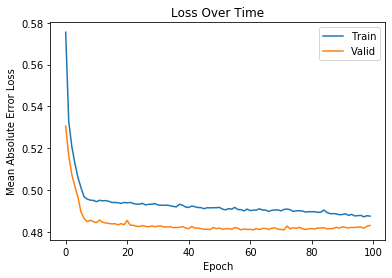

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [8]:
from tensorflow.keras.models import model_from_json

file_name = "models/enc_dec_o2o_100_20_train"
# serialize model to JSON
model_json = train.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
train.save_weights(f"{file_name}.h5")

file_name = "models/enc_dec_o2o_100_20_enc"
# serialize model to JSON
model_json = inf_encoder_model.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
inf_encoder_model.save_weights(f"{file_name}.h5")

file_name = "models/enc_dec_o2o_100_20_dec"
# serialize model to JSON
model_json = inf_decoder_model.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
inf_decoder_model.save_weights(f"{file_name}.h5")

In [4]:
from tensorflow.keras.models import model_from_json

file_name = "models/enc_dec_o2o_100_20_train"
# load json and create model
json_file = open(f'{file_name}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
train = model_from_json(loaded_model_json)
# load weights into new model
train.load_weights(f"{file_name}.h5")
print("Loaded model from disk")

file_name = "models/enc_dec_o2o_100_20_enc"
# load json and create model
json_file = open(f'{file_name}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
inf_encoder_model = model_from_json(loaded_model_json)
# load weights into new model
inf_encoder_model.load_weights(f"{file_name}.h5")
print("Loaded model from disk")

file_name = "models/enc_dec_o2o_100_20_dec"
# load json and create model
json_file = open(f'{file_name}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
inf_decoder_model = model_from_json(loaded_model_json)
# load weights into new model
inf_decoder_model.load_weights(f"{file_name}.h5")
print("Loaded model from disk")


Loaded model from disk
Loaded model from disk
Loaded model from disk


In [5]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int, enc_tail_len=100):
    encode_series = encoder_input_data[0][sample_ix:sample_ix+1,:,:] 
    pred_series = models.decode_sequence_o2o(inf_encoder_model,
                                             inf_decoder_model, 
                                             input_seq=encode_series,
                                             pred_steps=pred_steps)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    print(f"Correlation: {r}. P: {p}. mae: {mae}")
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [6]:
val_batch = val_generator[0]

In [7]:
len(val_batch[0][0])

1024

Correlation: 0.28309294727671563. P: 0.22649180276062722. mae: 0.5602615583009235


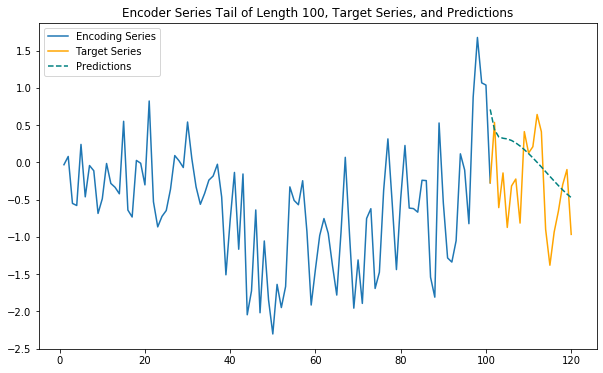

In [8]:
predict_and_plot(val_batch[0], val_batch[1], sample_ix=0, pred_steps=20)

In [9]:
def get_corr_mae(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int,
                 enc_tail_len=100, verbose=True):
    encode_series = encoder_input_data[0][sample_ix:sample_ix+1,:,:] 
    pred_series = models.decode_sequence_o2o(inf_encoder_model,
                                             inf_decoder_model, 
                                             input_seq=encode_series,
                                             pred_steps=pred_steps)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [10]:
encoder_input_data = val_batch[0]
encoder_target_data = val_batch[1]

In [29]:
n_rows = val_batch[0][0].shape[0] // 2
r_array = np.empty(shape=(n_rows,))
z_array = np.empty(shape=(n_rows,))

sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(encoder_input_data,
                          encoder_target_data,
                          sample_ix=sample_ix,
                          pred_steps=20,
                          verbose=False)
    r_array[sample_ix] = r
    z_array[sample_ix] = 0.5 * np.log((1 + r)/(1-r))
    sample_maes[sample_ix] = mae
z_mean = np.mean(z_array)
batch_r = (np.exp(2 * z_mean) - 1)/(np.exp(2 * z_mean) + 1)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Absolute Batch_r: {np.mean(np.abs(r_array))}")
print(f"Batch Mae: {batch_mae}")

Batch_r: 0.11111117042396262
Absolute Batch_r: 0.2961273257319346
Batch Mae: 0.5931564011099011


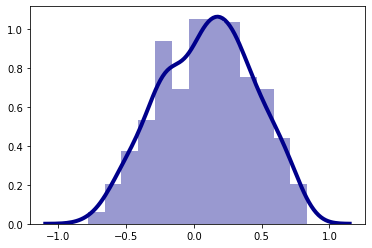

In [20]:
# Plot the distribution of r
import seaborn as sns
sns.distplot(r_array, kde=True, color = 'darkblue',
             kde_kws={'linewidth': 4})

In [21]:
k = 5
top_k_r = np.abs(r_array).argsort()[-k:]
print(top_k_r)

[217 166 402  20 456]


Correlation: -0.7838500199965884. P: 4.327986375919087e-05. mae: 1.432435992586506
Correlation: 0.7863255943418705. P: 3.940114740009158e-05. mae: 0.43496792163208237
Correlation: 0.8021083374435378. P: 2.1016083015151963e-05. mae: 0.650009721435971
Correlation: 0.83371632915293. P: 4.963583175051545e-06. mae: 0.7535529231702517
Correlation: 0.8365371892348974. P: 4.3018283903400955e-06. mae: 0.6372148332476384


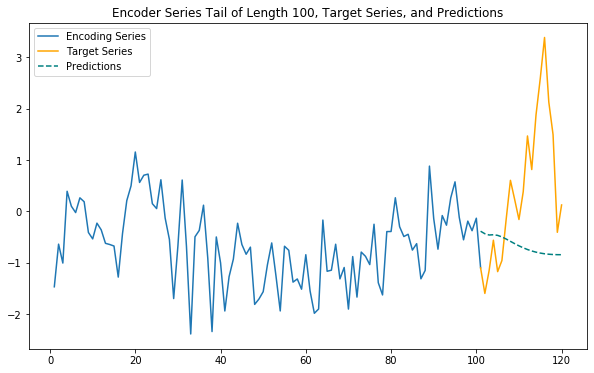

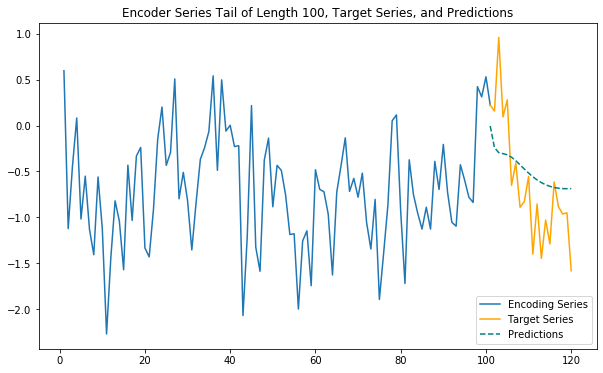

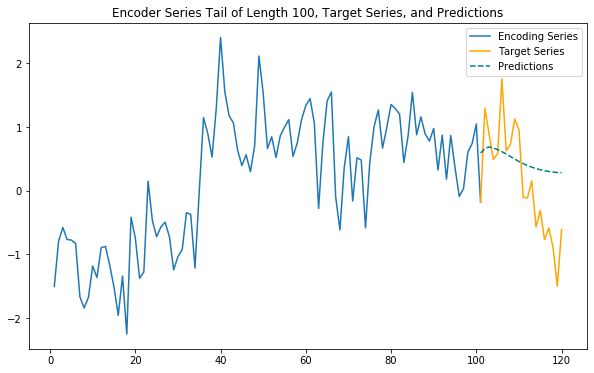

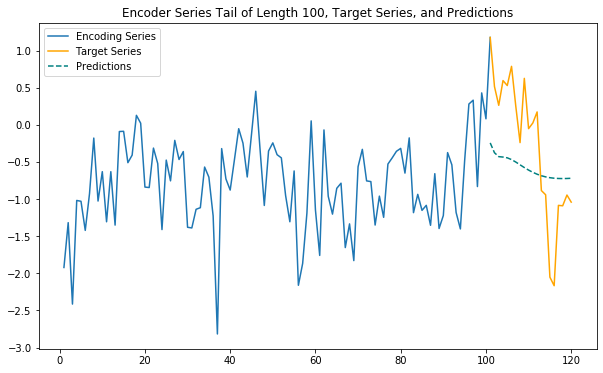

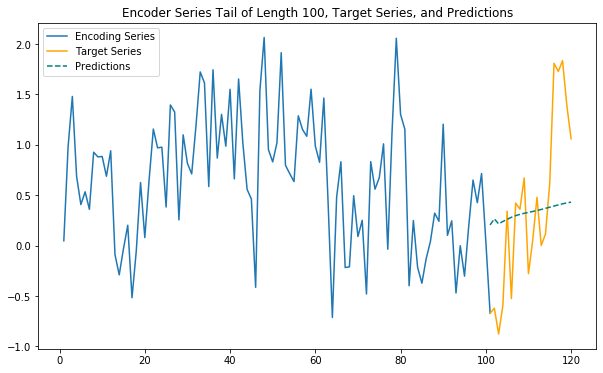

In [22]:
for i in top_k_r:
    predict_and_plot(val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=20)

In [23]:
k = 5
top_k_mae = sample_maes.argsort()[:k]
print(top_k_mae)

[188 477 212 110 418]


Correlation: -0.09321956319404172. P: 0.6958709543851083. mae: 0.2819573122906027
Correlation: -0.03590113313436358. P: 0.8805559610589793. mae: 0.28555655108398936
Correlation: 0.05510419722445534. P: 0.8175164101107624. mae: 0.2942238275927308
Correlation: -0.13033312780908374. P: 0.583910130229658. mae: 0.30393065053162227
Correlation: 0.3138455078872879. P: 0.17780999335286596. mae: 0.30692698891887255


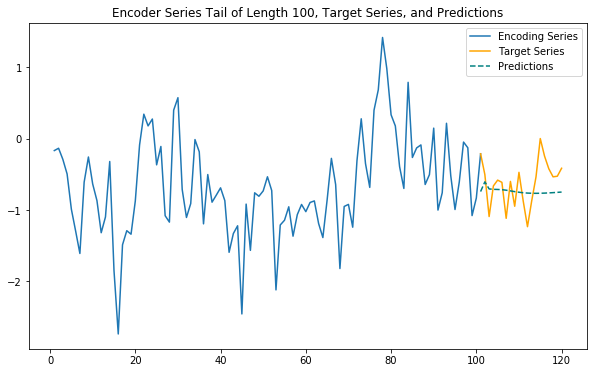

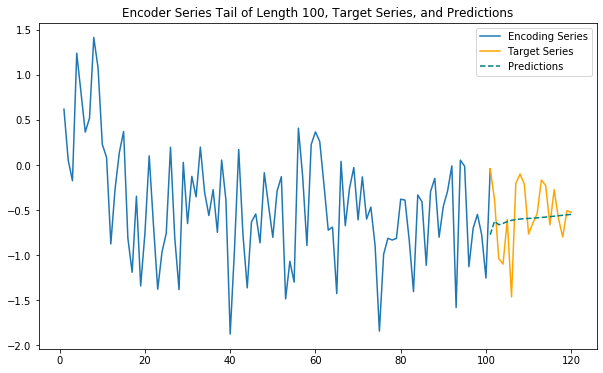

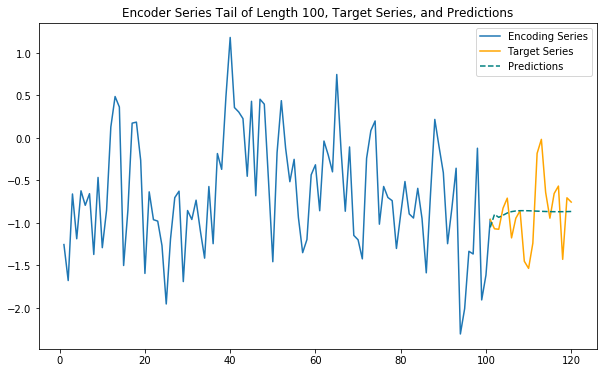

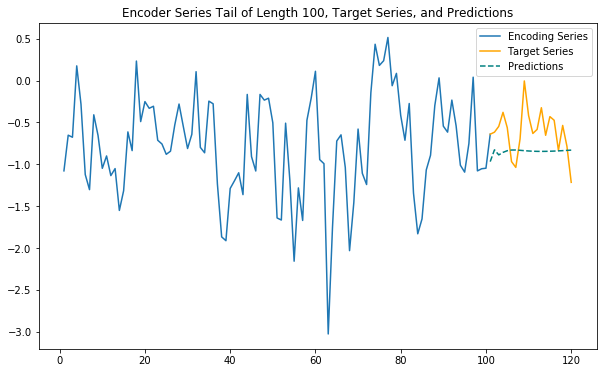

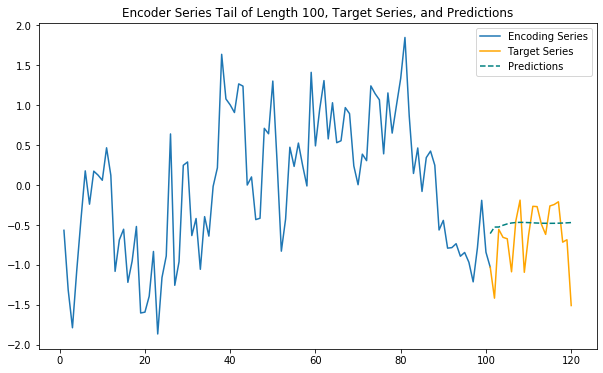

In [24]:
for i in top_k_mae:
    predict_and_plot(val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=20)

In [11]:
def predict_sequence_o2o_window(input_sequence,
                                pred_steps,
                                inf_encoder_model,
                                inf_decoder_model,
                                lookback=lookback):
    history_sequence = input_sequence.reshape((1, lookback, 1))
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)
        last_step_pred = last_step_pred.reshape(-1)

        pred_sequence[i] = last_step_pred[-1]
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           last_step_pred[-1].reshape(1, 1, 1)], axis=1)

    return pred_sequence

def moving_window_pred_o2o(input_sequence,
                           lookback,
                           pred_steps,
                           electrode_count,
                           inf_encoder_model,
                           inf_decoder_model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    final_array = np.empty(shape=(input_sequence.shape[0], electrode_count))
    print(final_array.shape)
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end] = input_sequence[w_start : w_end]
    while w_end + pred_steps < input_sequence.shape[0]:
        window_lookback = input_sequence[w_start: w_end].reshape((1, lookback, 1))
#         pred_seq = predict_sequence_o2o_window(window_lookback,
#                                                pred_steps,
#                                                model,
#                                                lookback=lookback)
        pred_seq = models.decode_sequence_o2o(inf_encoder_model,
                                                 inf_decoder_model, 
                                                 input_seq=window_lookback,
                                                 pred_steps=pred_length)
        final_array[w_end:w_end+pred_steps] = pred_seq.reshape(pred_steps, electrode_count)
        w_start += pred_steps
        w_end += pred_steps
    return final_array

def get_corr_mae_conv(input_seq,
                      lookback,
                      pred_length,
                      electrode_count,
                      electrode,
                      inf_encoder_model,
                      inf_decoder_model,
                      enc_tail_len=100,
                      verbose=True):
    
    
    input_seq = input_seq[:,electrode].reshape(input_seq.shape[0], electrode_count)

    predicted_series = moving_window_pred_o2o(input_seq,
                                              lookback = lookback,
                                              pred_steps = pred_length,
                                              electrode_count=electrode_count,
                                              inf_encoder_model=inf_encoder_model,
                                              inf_decoder_model=inf_decoder_model)
    
    input_seq = input_seq[lookback:,:]

    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

def get_corr_mae_conv_step(input_seq,
                           lookback,
                           k,
                           pred_length,
                           electrode_count,
                           electrode,
                           inf_encoder_model,
                           inf_decoder_model,
                           enc_tail_len=100,
                           verbose=True):
    
    
    input_seq = input_seq[:,electrode].reshape((input_seq.shape[0], electrode_count))

    predicted_series = moving_window_pred_o2o_step(input_seq,
                                                   lookback = lookback,
                                                   k=k,
                                                   pred_steps = pred_length,
                                                   electrode_count=electrode_count,
                                                   inf_encoder_model=inf_encoder_model,
                                                   inf_decoder_model=inf_decoder_model)
    
    input_seq = input_seq[lookback:,:]

    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

def moving_window_pred_o2o_step(input_sequence,
                                lookback,
                                pred_steps,
                                k,
                                electrode_count,
                                inf_encoder_model,
                                inf_decoder_model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    final_array = np.empty(shape=(input_sequence.shape[0], electrode_count))
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end + k, :] = input_sequence[w_start : w_end + k, :]
    print(final_array.shape)
    full_length = int(len(input_sequence))
    print(full_length)
    i = w_end + k
    while i < full_length:
        window_lookback = np.array([input_sequence[w_start: w_end]]).reshape((1, lookback, 1))
        #print(window_lookback.shape)
        #pred_steps = model.predict(window_lookback)
        pred_steps = models.decode_sequence_o2o(inf_encoder_model,
                                                inf_decoder_model, 
                                                input_seq=window_lookback,
                                                pred_steps=pred_length)
#         print(pred_steps.reshape((20, 1)))
#         print(pred_steps.shape)
        final_array[w_end + k] = pred_steps[:,k,:].reshape((1, 1))
        w_end += 1
        w_start += 1
        i += 1
    return final_array

In [12]:
val_paths = val_paths

In [13]:
data = np.load(val_paths[0])

(2048, 1)
Correlation: 0.507339813180199. P: 6.302709745191715e-128. MAE: 0.5995109266039624


(0.507339813180199, 0.5995109266039624)

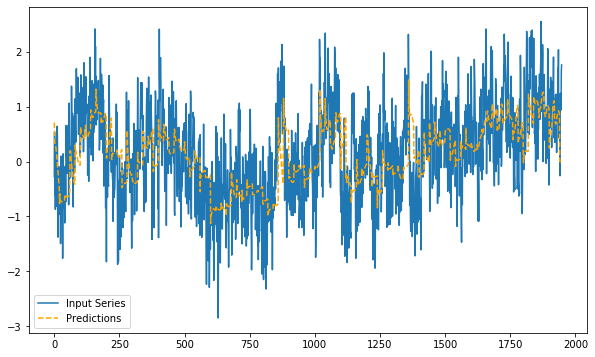

In [50]:
get_corr_mae_conv(data[:2048,:],
                  lookback,
                  pred_length,
                  electrode_count=1,
                  electrode=electrode,
                  inf_encoder_model=inf_encoder_model,
                  inf_decoder_model=inf_decoder_model)

(1100, 1)
Correlation: 0.4840268958848952. P: 7.350850629308954e-60. MAE: 0.5809750075300573


(0.4840268958848952, 0.5809750075300573)

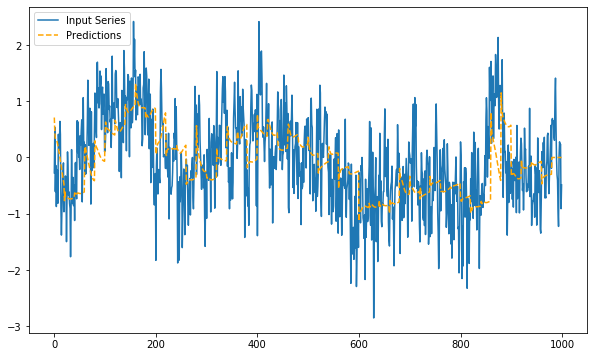

In [53]:
get_corr_mae_conv(data[:1100,:],
                  lookback,
                  pred_length,
                  electrode_count=1,
                  electrode=electrode,
                  inf_encoder_model=inf_encoder_model,
                  inf_decoder_model=inf_decoder_model)

(1100, 1)
1100
Correlation: 0.6941932458103071. P: 1.1243966605962702e-144. MAE: 0.4696040631840729


(0.6941932458103071, 0.4696040631840729)

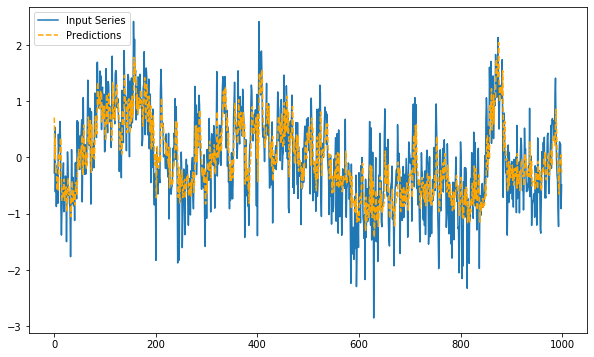

In [15]:
get_corr_mae_conv_step(data[:1100,:],
                  lookback,0,
                  pred_length,
                  electrode_count=1,
                  electrode=electrode,
                  inf_encoder_model=inf_encoder_model,
                  inf_decoder_model=inf_decoder_model)

(2100, 1)
2100
Correlation: 0.7118196500884983. P: 6.7337375616902e-309. MAE: 0.48139826737771263


(0.7118196500884983, 0.48139826737771263)

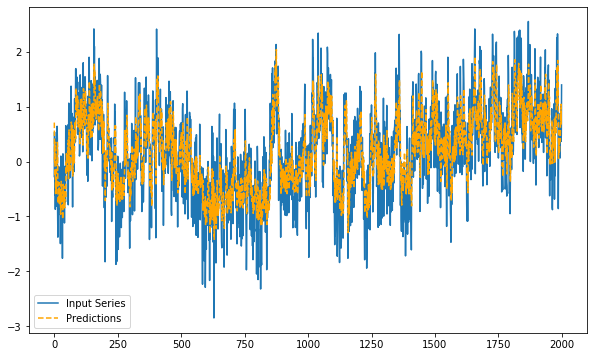

In [16]:
get_corr_mae_conv_step(data[:2100,:],
                  lookback,0,
                  pred_length,
                  electrode_count=1,
                  electrode=electrode,
                  inf_encoder_model=inf_encoder_model,
                  inf_decoder_model=inf_decoder_model)

(1100, 1)
1100
Correlation: 0.52578316666873. P: 3.5954465192097244e-72. MAE: 0.5590346851184215


(0.52578316666873, 0.5590346851184215)

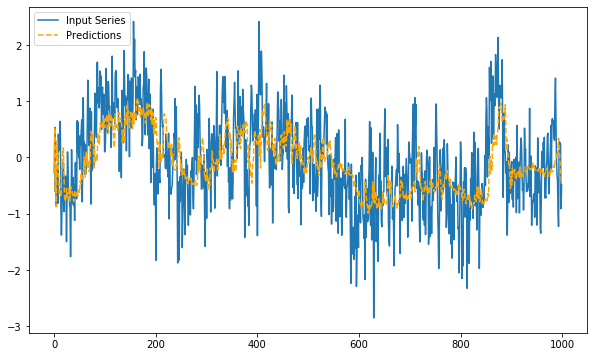

In [17]:
get_corr_mae_conv_step(data[:1100,:],
                  lookback,5,
                  pred_length,
                  electrode_count=1,
                  electrode=electrode,
                  inf_encoder_model=inf_encoder_model,
                  inf_decoder_model=inf_decoder_model)

(1100, 1)
1100
Correlation: 0.45104222991665405. P: 2.8486552848312624e-51. MAE: 0.5891480977690032


(0.45104222991665405, 0.5891480977690032)

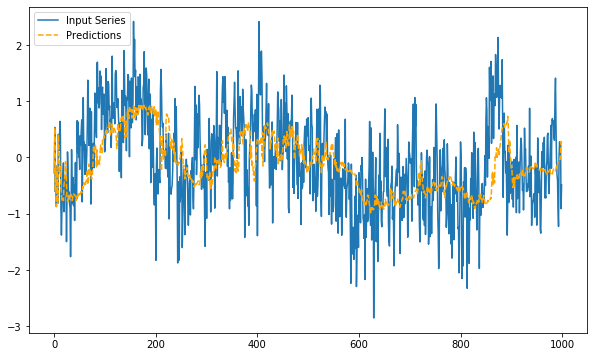

In [18]:
get_corr_mae_conv_step(data[:1100,:],
                  lookback,10,
                  pred_length,
                  electrode_count=1,
                  electrode=electrode,
                  inf_encoder_model=inf_encoder_model,
                  inf_decoder_model=inf_decoder_model)

(500, 1)
500
Correlation: 0.4647876048113556. P: 7.87914608559181e-23. MAE: 0.5613291838045221


(0.4647876048113556, 0.5613291838045221)

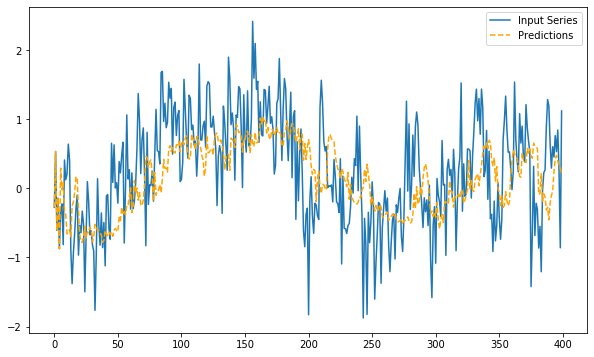

In [19]:
get_corr_mae_conv_step(data[:500,:],
                  lookback,5,
                  pred_length,
                  electrode_count=1,
                  electrode=electrode,
                  inf_encoder_model=inf_encoder_model,
                  inf_decoder_model=inf_decoder_model)

# TEST DATA

In [14]:
test_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/test_676_bin_norm_2.txt")

In [15]:
test_paths[0]

'/projects/HASSON/247/data/binned_conversations/676_bin_norm_2/bin_norm_2_NY676_618_Part5-one_conversation1/bin_norm_2_NY676_618_Part5-one_conversation1.npy'

In [16]:
for path in test_paths:
    utils.get_file_shape(path)

(163846, 114)
(102096, 114)
(73475, 114)
(33158, 114)
(17795, 114)
(64950, 114)
(92170, 114)
(83951, 114)
(42936, 114)
(21311, 114)


In [17]:
test_data = np.load(test_paths[0])

(1100, 1)
Correlation: 0.15839501104908604. P: 4.792491195266958e-07. MAE: 0.7426531049530678


(0.15839501104908604, 0.7426531049530678)

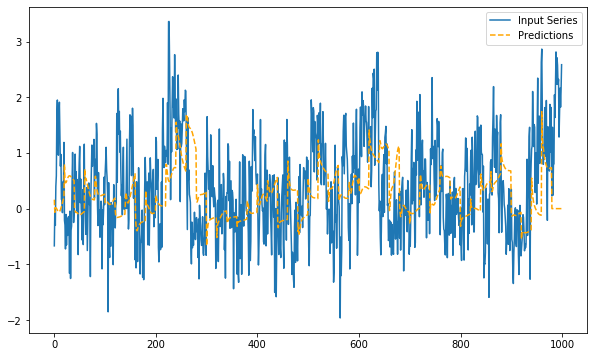

In [19]:
get_corr_mae_conv(test_data[:1100,:],
                  lookback,
                  pred_length,
                  electrode_count=1,
                  electrode=electrode,
                  inf_encoder_model = inf_encoder_model,
                  inf_decoder_model = inf_decoder_model)

(350, 1)
Correlation: 0.19405870259743419. P: 0.0020539761335249453. MAE: 0.6443769397388246


(0.19405870259743419, 0.6443769397388246)

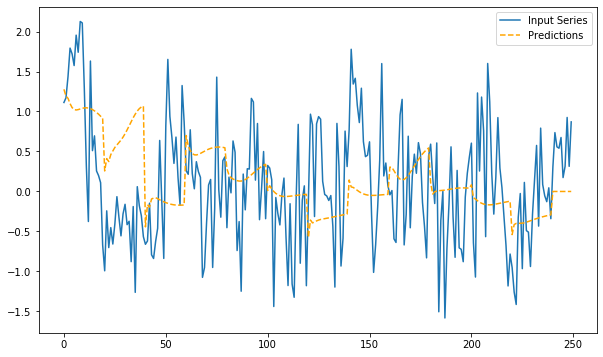

In [20]:
get_corr_mae_conv(test_data[250:600,:],
                  lookback,
                  pred_length,
                  electrode_count=1,
                  electrode=electrode,
                  inf_encoder_model = inf_encoder_model,
                  inf_decoder_model = inf_decoder_model)

(2100, 1)
Correlation: 0.3051722243864739. P: 2.2511397771424307e-44. MAE: 0.6964983359439397


(0.3051722243864739, 0.6964983359439397)

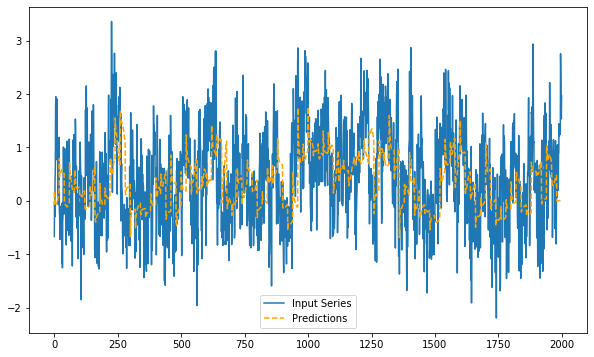

In [21]:
get_corr_mae_conv(test_data[:2100,:],
                  lookback,
                  pred_length,
                  electrode_count=1,
                  electrode=electrode,
                  inf_encoder_model = inf_encoder_model,
                  inf_decoder_model = inf_decoder_model)

In [ ]:
get_corr_mae_conv_step(test_data[:200,:], lookback, 0, pred_length, electrode_count=1, electrode=electrode, model=model)

In [ ]:
get_corr_mae_conv_step(test_data[:2100,:], lookback, 0, pred_length, electrode_count=1, electrode=electrode, model=model)

In [ ]:
get_corr_mae_conv_step(test_data[:2100,:], lookback, 5, pred_length, electrode_count=1, electrode=electrode, model=model)

In [ ]:
get_corr_mae_conv_step(test_data[:2100,:], lookback, 5, pred_length, electrode_count=1, electrode=electrode, model=model)

In [22]:
# Test_gene
test_generator = generators.FGenerator(file_paths=test_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=2048,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False)

In [23]:
len(test_generator)

2

In [24]:
test_batch = test_generator[0]

In [25]:
encoder_input_data = test_batch[0]
encoder_target_data = test_batch[1]

In [31]:
def get_corr_mae(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int,
                 enc_tail_len=100, verbose=True):
    encode_series = encoder_input_data[sample_ix:sample_ix+1,:,:] 
    pred_series = models.decode_sequence_o2o(inf_encoder_model,
                                             inf_decoder_model, 
                                             input_seq=encode_series,
                                             pred_steps=pred_steps)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [32]:
n_rows = int(encoder_input_data.shape[0]//2)
r_array = np.empty(shape=(n_rows,))
z_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(encoder_input_data,
                          encoder_target_data,
                          sample_ix=sample_ix,
                          pred_steps=20,
                          verbose=False)
    r_array[sample_ix] = r
    z_array[sample_ix] = 0.5 * np.log((1 + r)/(1-r))
    sample_maes[sample_ix] = mae
z_mean = np.mean(z_array)
batch_r = (np.exp(2 * z_mean) - 1)/(np.exp(2 * z_mean) + 1)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Absolute Batch_r: {np.mean(np.abs(r_array))}")
print(f"Batch Mae: {batch_mae}")

Batch_r: 0.0812600106471816
Absolute Batch_r: 0.2894072007506374
Batch Mae: 0.6293359603001738
